# Steps for training detectron2 on custom data

### Loading necessary libraries

In [1]:
import h5py
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
%config Completer.use_jedi = False


os.chdir("C:/Users/admin/Documents/Python Scripts/Soma-Segmentation/train")
from utils import ImageJ2COCO
from config import configuration
from segmentation_predictor import predict_img


#from train import run_train
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer

from detectron2.engine import DefaultPredictor

### Registering data

In [2]:
# if data already is in COCO style
register_coco_instances("train", {}, "I:/Sina/Medical report segmentation/publaynet/train.json", 
                        "I:/Sina/Medical report segmentation/publaynet/train")
register_coco_instances("val", {}, "I:/Sina/Medical report segmentation/publaynet/val.json", 
                        "I:/Sina/Medical report segmentation/publaynet/val")


#MetadataCatalog.get("val").set(thing_classes=["title", "text", "figure", "table", "list"])
#MetadataCatalog.get("train").set(thing_classes=["title", "text", "figure", "table", "list"])

In [ ]:
# for custom data with custom written dataloader

# dataloader for train dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_train = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                       label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                       output_path="C:/Users/admin/Desktop/COCO test2", 
                       start_index=[10000, 12000], 
                       end_index=[12000, 14000], 
                       image_nr=[1400, 1500], 
                       id_starter=[1, 2000], 
                       min_intensity = [100, 100], 
                       max_intensity = [4000, 3000], 
                       key = ["GroupHierarchy.Groups.Datasets", 
                              "GroupHierarchy.Groups.Datasets"])

# dataloader for validation dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_val = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                       label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                       output_path="C:/Users/admin/Desktop/COCO test2", 
                       start_index=[1000, 1200], 
                       end_index=[20000, 40000], 
                       image_nr=[800, 800], 
                       id_starter=[3000, 4000], 
                       min_intensity = [100, 100], 
                       max_intensity = [4000, 3000], 
                       key = ["GroupHierarchy.Groups.Datasets", 
                              "GroupHierarchy.Groups.Datasets"])

# register train data set
DatasetCatalog.register("train", img2coco_train.transform)
MetadataCatalog.get("train").set(thing_classes=["soma"]) # define classes as well

# register validation data set
DatasetCatalog.register("val", img2coco_val.transform)
MetadataCatalog.get("val").set(thing_classes=["soma"]) # define classes as well

metadata = MetadataCatalog.get("train")

### Check visually the data load step

In [ ]:
# prepare data

mydata = DatasetCatalog.get("train")
mydata_metdata = MetadataCatalog.get("train")

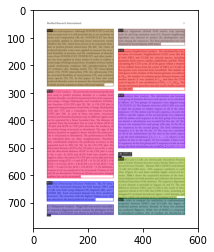

In [10]:
# plot
%matplotlib inline

for d in random.sample(mydata, 1):    
    im = cv2.imread(d["file_name"])
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydata_metdata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### Model configuration

In [3]:
# configuration file
cfg = configuration(num_classes=5,
                    train_output_path="C:/Users/admin/Desktop/test/out",
                    min_image_size=440,
                    image_per_batch=1,
                    max_iter=15000, 
                    base_lr = 0.0001,
                    model_weights="C:/Users/admin/Desktop/test/out/model_final.pth", # if you have another weights give that one
                    validation=True) # if you have validation turn it to True

In [7]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'C:/Users/admin/Desktop/test/out/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_

### Model training

In [ ]:
# start training

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/12 09:52:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/12 09:53:56 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/train.json takes 94.31 seconds.
[10/12 09:53:59 d2.data.datasets.coco]: Loaded 335703 images in COCO format from I:/Sina/Medical report segmentation/publaynet/train.json
[10/12 09:54:27 d2.data.build]: Removed 0 images with no usable annotations. 335703 images left.
[10/12 09:54:43 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    text    | 2343356      |   title    | 627125       |    list    | 80759        |
|   table    | 102514       |   figure   | 109292       |            |              |
|   total    | 3263046      |            |              |            |              |
[10/12 09:54:43 d2.data.common]: Serializing 335703 elements to byte tensors and concatenating them all ...
[10/12 09:55:03 d2.

c:\users\admin\detectron2-windows\detectron2\layers\wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/12 09:55:45 d2.utils.events]:  eta: 1:14:55  iter: 19  total_loss: 1.081  loss_cls: 0.168  loss_box_reg: 0.196  loss_mask: 0.109  loss_rpn_cls: 0.087  loss_rpn_loc: 0.467  time: 0.3011  data_time: 1.1122  lr: 0.000002  max_mem: 1287M
[10/12 09:55:51 d2.utils.events]:  eta: 1:15:09  iter: 39  total_loss: 0.990  loss_cls: 0.160  loss_box_reg: 0.214  loss_mask: 0.116  loss_rpn_cls: 0.095  loss_rpn_loc: 0.418  time: 0.3023  data_time: 0.0012  lr: 0.000004  max_mem: 1287M
[10/12 09:55:57 d2.utils.events]:  eta: 1:14:58  iter: 59  total_loss: 1.082  loss_cls: 0.202  loss_box_reg: 0.240  loss_mask: 0.162  loss_rpn_cls: 0.100  loss_rpn_loc: 0.396  time: 0.3013  data_time: 0.0011  lr: 0.000006  max_mem: 1287M
[10/12 09:56:03 d2.utils.events]:  eta: 1:14:57  iter: 79  total_loss: 1.185  loss_cls: 0.195  loss_box_reg: 0.261  loss_mask: 0.157  loss_rpn_cls: 0.094  loss_rpn_loc: 0.387  time: 0.3026  data_time: 0.0011  lr: 0.000008  max_mem: 1287M
[10/12 09:56:10 d2.utils.events]:  eta: 1:14:58 

### Model prediction

In [ ]:
# on single image

# save result's image
save_img = False

# get dir path to image
img_path = ""

# model weights (after training)
model_weights_path = ""

# path for saving final results
save_path = ""

# get configuration file same as used during training
cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/COCO test2/out",
                    min_image_size=240,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=False)

# initialize main dataframe
df = pd.DataFrame()


df = predict_img(cfg=cfg, img_path=img_path, save_path=save_path,
                   img_save=save_img, df_save=False, score_thresh=0.7)

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

In [ ]:
# on multiple images

# save result's image
save_img = False

# get dir path to images
imgs_path = ""

# get images info
imgs = os.listdir(imgs_path)

# model weights (after training)
model_weights_path = ""

# path for saving final results
save_path = ""

# get configuration file same as used during training
cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/COCO test2/out",
                    min_image_size=240,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=False)

# initialize main dataframe
df = pd.DataFrame()

# starting looping results
for img in imgs:
    df = df.append(predict_img(cfg=cfg, img_path=img, save_path=save_path,
                               img_save=save_img, df_save=False, score_thresh=0.7), ignore_index=True)

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)